# Transfer Learning - Project

- https://huggingface.co/docs/transformers/tasks/image_classification

## Task 1: Transfer Learning for Emotion Recognition

In this project, you will use a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224-in21k) model pre-trained on ImageNet-21k and fine-tune it on the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset for emotion recognition, with the final step being the publication of your trained model to the Hugging Face Model Hub.

### Step 1: Environment Setup

In this section, we start by installing the necessary packages and logging into Hugging Face's platform:
- `transformers`
- `datasets`
- `evaluate`
- `huggingface_hub`

In [ ]:
# Install necessary packages

# Put your code here:

!pip -q install gradio
!pip -q install transformers
!pip -q install datasets
!pip -q install evaluate
!pip -q install huggingface_hub
# !pip -q install transformers[torch]

# ---- End of your code ----

ERROR: Operation cancelled by user


In [ ]:
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

After installing, use the Hugging Face's notebook login function to log into Hugging Face's platform. Execute the following commands in your cell:

In [ ]:
# Log into Hugging Face's platform

# Put your code here:

from huggingface_hub import notebook_login

notebook_login()

# ---- End of your code ----

### Step 2: Load the Dataset

Load the "FastJobs/Visual_Emotional_Analysis" dataset and split it into training and test sets with a test size of 0.2.

> **Note**: please assign to variable `emotion`

In [ ]:
# Load the dataset and split it

# Update your code here:

emotion = load_dataset("FastJobs/Visual_Emotional_Analysis")

# ---- End of your code ----

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
emotion

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [ ]:
example = emotion["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

In [ ]:
emotion["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

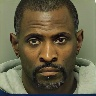

In [ ]:
example['image']

In [ ]:
example['label']

0

In [ ]:
emotion["train"].features["label"]

ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)

**Label Mapping**

> **Note**: no need to change the code below! Just run it to map labels from the dataset.

In [ ]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'disgust'

### Step 3: Explore and Visualize the Dataset

In this step, you are required to visualize the first instance in the training dataset.

> **Note**: no need to change the code below! Just run it to visualize the dataset based on index.

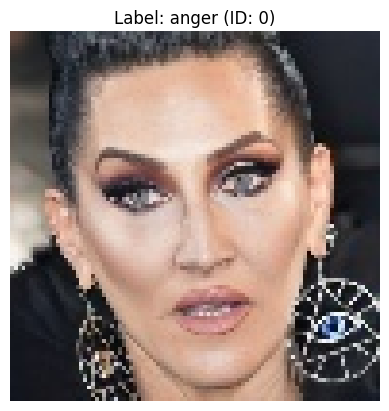

In [ ]:
import matplotlib.pyplot as plt

# Define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# Use first training example
image = emotion['train'][0]['image'] # Explore image by index
label_id = str(emotion['train'][0]['label'])
label_name = id2label_view[label_id]

# Display the image and its corresponding label
plt.imshow(image)
plt.title(f'Label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

### Step 4: Preprocess the Data

You need to define the transformation function for image preprocessing and apply it to the dataset.

In [ ]:
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

# Load the image processor, Define the transforms, Define the transformation function and Apply the transformation function

# Put your code here:

image_processor  = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


In [ ]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
emotion = emotion['train'].train_test_split(test_size=0.2)

In [ ]:
emotion_train = emotion['train']
emotion_test = emotion['test']

In [ ]:
emotion_train.set_transform(preprocess_train)
emotion_test.set_transform(preprocess_val)

In [ ]:
emotion_train[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0,
 'pixel_values': tensor([[[0.7098, 0.7098, 0.7098,  ..., 0.5529, 0.5529, 0.5529],
          [0.7098, 0.7098, 0.7098,  ..., 0.5529, 0.5529, 0.5529],
          [0.7098, 0.7098, 0.7098,  ..., 0.5529, 0.5529, 0.5529],
          ...,
          [0.6078, 0.6078, 0.6078,  ..., 0.1216, 0.3333, 0.3333],
          [0.6078, 0.6078, 0.6078,  ..., 0.1137, 0.3255, 0.3255],
          [0.6078, 0.6078, 0.6078,  ..., 0.1137, 0.3255, 0.3255]],
 
         [[0.7098, 0.7098, 0.7098,  ..., 0.5686, 0.5686, 0.5686],
          [0.7098, 0.7098, 0.7098,  ..., 0.5686, 0.5686, 0.5686],
          [0.7098, 0.7098, 0.7098,  ..., 0.5686, 0.5686, 0.5686],
          ...,
          [0.6000, 0.6000, 0.6000,  ..., 0.0667, 0.2863, 0.2863],
          [0.6000, 0.6000, 0.6000,  ..., 0.0667, 0.2863, 0.2863],
          [0.6000, 0.6000, 0.6000,  ..., 0.0667, 0.2863, 0.2863]],
 
         [[0.7255, 0.7255, 0.7255,  ..., 0.5608, 0.5608, 0.5608],
    

In [ ]:
# ---- End of your code ----

### Step 5: Model Setup

In this step, define the model architecture with the pre-trained ViT model and load it.

In [ ]:
from transformers import AutoModelForImageClassification

# Define the model

# Put your code here:

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    # num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

# ---- End of your code ----

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 6: Training Setup

Define the training arguments and instantiate the trainer.

In [ ]:
import evaluate

# Load accuracy metric

# Put your code here:

accuracy = evaluate.load("accuracy")

# ---- End of your code ----

In [ ]:
# Define compute metric function

# Put your code here:

import numpy as np
from sklearn.metrics import precision_recall_fscore_support


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)

    labels = eval_pred.label_ids

    acc = accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': acc['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# ---- End of your code ----

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments

# Update your code here:

batch_size = 32
gradient_accumulation_steps = 3
num_train_epochs = 100

training_args = TrainingArguments(
    f"visual-emotion-recognition",
    remove_unused_columns=False, # sebelumnya tidak ada makanya error
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    lr_scheduler_type="linear",
    push_to_hub=True
)

# ---- End of your code ----

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=len(emotion_train) * training_args.num_train_epochs)

To use Hugging Face `Trainer` you need to install the `accelerate` library version `0.20.1` or later. It is used for performance enhancement on PyTorch.

In [ ]:
%pip install accelerate -U

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from transformers import DefaultDataCollator

# Instantiate the trainer

# Update your code here:
# data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=emotion_train,
    eval_dataset=emotion_test,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler),
)
# ---- End of your code ----

If there are problems when using the Trainer after installing `accelerate` you can restart the Kernel

### Step 7: Train and Evaluate the Model

Now, you are ready to train the model and evaluate it on the test set.

In [ ]:
# Train the model

# Put your code here:
trainer.train()
# ---- End of your code ----

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,2.081100,2.091125,0.085938,0.053415,0.085938,0.065756
1,2.066800,2.083038,0.101562,0.065393,0.101562,0.075780
3,2.044500,2.064346,0.132812,0.096540,0.132812,0.099980
4,2.019800,2.053703,0.179688,0.191088,0.179688,0.160395
6,1.993700,2.024086,0.187500,0.177299,0.187500,0.159457
7,1.971100,2.007805,0.203125,0.193895,0.203125,0.173671
9,1.918400,1.966263,0.296875,0.320316,0.296875,0.260871
10,1.904200,1.942833,0.304688,0.341030,0.304688,0.271073
12,1.844900,1.885834,0.320312,0.464846,0.320312,0.283513
13,1.801900,1.857216,0.320312,0.485624,0.320312,0.292397


TrainOutput(global_step=500, training_loss=1.1632317271232604, metrics={'train_runtime': 1317.7962, 'train_samples_per_second': 38.853, 'train_steps_per_second': 0.379, 'total_flos': 3.719815527923712e+18, 'train_loss': 1.1632317271232604, 'epoch': 93.75})

In [ ]:
# Evaluate the model

# Update your code here:
eval_result = trainer.evaluate()
# ---- End of your code ----

# Save the formatted accuracy in a variable
accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

In [ ]:
accuracy_str

'0.6172'

### Step 8: Publishing the Trained Model

Finally, make sure to push your trained model to the Hugging Face Model Hub.

> **Note**: No need to change the code below! Just run to publish your model.

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1707677078.fd75205e2bee.1951.6:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1707675595.fd75205e2bee.1951.5:   0%|          | 0.00/64.6k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Firdho/visual-emotion-recognition/commit/e2dcc8cee1a7855a979dad216132091707f2f890', commit_message='End of training', commit_description='', oid='e2dcc8cee1a7855a979dad216132091707f2f890', pr_url=None, pr_revision=None, pr_num=None)

### Step 9: Inference

In [ ]:
import requests

from PIL import Image
from io import BytesIO

r = requests.get('https://awsimages.detik.net.id/community/media/visual/2023/11/20/zee-jkt48-2.jpeg?w=600&q=90') # Zee JKT48
im = Image.open(BytesIO(r.content))

print(r.content)

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x02\xee\x02X\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x01\x05\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\x06\x07\x08\t\xff\xc4\x00H\x10\x00\x01\x03\x02\x05\x02\x04\x04\x03\x07\x02\x05\x02\x05\x03\x05\x01\x00\x02\x11\x03!\x04\x05\x121AQa\x06\x13"q\x072\x81\x91\x14\xa1\xb1\x08#BR\xc1\xd1\xf0\x15\xe13br\x82\xf1\x16$%5CS\x924c\xa2

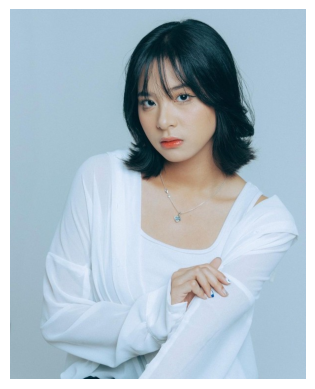

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis('off')
plt.show()

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "Firdho/visual-emotion-recognition"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
encoding = image_processor(im.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: contempt


In [ ]:
predicted_label = logits.softmax(1)
print(predicted_label)

result = predicted_label.argmax(1)
print(result)

print(model.config.id2label[result.item()])

predicted_label = logits.softmax(1)
    result = predicted_label.argmax(1)


tensor([[0.0642, 0.2210, 0.0907, 0.0950, 0.1425, 0.1894, 0.0828, 0.1143]])
tensor([1])
contempt


Once you've trained your model and pushed it to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

The following link is an example of what a trained model's page looks like: https://huggingface.co/aditira/emotion_classification. This is not your model, but rather an example of what your final result might resemble.

Remember, for this project you should push your output model to your own Hugging Face account. The link for your model will be different and should reflect your own username and model name.

In [ ]:
# Submit Method
huggingface_model_link = "https://huggingface.co/Firdho/visual-emotion-recognition" # Put your model link

assignment_id = "00_transfer_learning"
question_id = "00_emotion_recognition_huggingface"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

question_id = "01_emotion_recognition_accuracy"
submit(student_id, name, assignment_id, accuracy_str, question_id, drive_link)

'Assignment successfully submitted'

## Task 2:  Build an Interactive Application with Gradio

In this task, you will be building an interactive application using Gradio that will use your fine-tuned emotion recognition model along with another pretrained model ('`nateraw/vit-age-classifier`') to guess the emotion and age from an input image.

Please make sure to:
- Install the necessary package (`gradio`) for creating the web-based interface.
- Load your fine-tuned model as well as the pretrained model '`nateraw/vit-age-classifier`'.
- Define a function that will take an image as input and return the predicted emotion and age.
- Utilize Gradio to create an Interface (UI) for your function, allowing users to upload images and see the predicted emotion and age.

In [ ]:
# Install Gradio
!pip -q install gradio

### Submisssion

![Upload colab](https://storage.googleapis.com/rg-ai-bootcamp/project-3-pipeline-and-gradio/upload-colab.png)

You need to submit screenshot of your Gradio's app. In Google Colab you can just use the "Folder" sidebar and click the upload button. Make sure your screenshot match below requirements:

- Image name screenshot is `submission.jpg`
- You should upload a person's image to that app
- The score should be included at the screenshot

https://www.youtube.com/watch?v=LIO-G7AVgBM

In [ ]:
# Put your code here:

import json
import torch

from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import AutoModelForImageClassification, AutoImageProcessor

def predict(input_image: gr.Image) -> json:

    im = Image.fromarray(input_image.astype('uint8'), 'RGB')

    # AGE
    age_model = ViTForImageClassification.from_pretrained('nateraw/vit-age-classifier')
    age_transforms = ViTFeatureExtractor.from_pretrained('nateraw/vit-age-classifier')

    age_inputs = age_transforms(im, return_tensors="pt")

    # EMOTION
    emotion_model = AutoModelForImageClassification.from_pretrained('Firdho/visual-emotion-recognition')
    emotion_processor = AutoImageProcessor.from_pretrained('Firdho/visual-emotion-recognition')

    emotion_inputs = emotion_processor(im.convert("RGB"), return_tensors="pt")


    with torch.no_grad():

        age_outputs = age_model(**age_inputs)
        age_logits = age_outputs.logits

        emotion_outputs = emotion_model(**emotion_inputs)
        emotion_logits = emotion_outputs.logits

    age_predicted_label = age_logits.softmax(1)
    age_result = age_predicted_label.argmax(1)

    emotion_predicted_label = emotion_logits.softmax(1)
    emotion_result = emotion_predicted_label.argmax(1)

    return (
        {
            "score": emotion_predicted_label[0, emotion_result.item()].item(),
            "label": emotion_model.config.id2label[emotion_result.item()]
        },
        {
            "score": age_predicted_label[0, age_result.item()].item(),
            "label": age_model.config.id2label[age_result.item()]
        }
    )



# ---- End of your code ----

In [ ]:
import gradio as gr

inputs = gr.Image(label='Upload image')
output = [
    gr.JSON(label="Emotion"),
    gr.JSON(label="Age")
]

iface = gr.Interface(fn=predict, inputs=inputs, outputs=output, title="Emotion and Age Detection")
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://491b74ec455c712b69.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Example of Expected Output:

![gradio-result](https://storage.googleapis.com/rg-ai-bootcamp/project-4-transfer-learning/gradio_emotion_age_app.png)

In [ ]:
# Submit Method
question_id = "01_interactive_application_with_gradio"
submit_image(student_id, question_id, '/content/Screenshot 2024-02-13 085445.png')

'Assignment successfully submitted'

> Note: If your submission for Task-2 did not run (After you run it never changes from "*" to a number), stop the Code block that's running the Gradio app, then the submission will run. To stop the Code block, you can click on the Code block and then click the stop button.